# Проверка гипотез и анализ A/B-тестирования

В нашем распоряжении данные крупного интернет-магазина, цель проекта - приоретизировать гипотезы 2 фреймворками RICE и ICE, а также проанализировать результаты, полученные в ходе проведения A/B теста.

## Изучение данных и предобработка

In [1]:
import numpy as np 
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 110  
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
part_1 = pd.read_csv('C:/Users/Анастасия/Documents/Jupiter_project/projects/decision_making_in_business/hypothesis.csv')
orders = pd.read_csv('C:/Users/Анастасия/Documents/Jupiter_project/projects/decision_making_in_business/orders.csv')
visitors = pd.read_csv('C:/Users/Анастасия/Documents/Jupiter_project/projects/decision_making_in_business/visitors.csv')

### part_1

In [4]:
def info (data): #функция для просмотра иформации об имеющихсся данных
    data.info()
    display(data.head(9))
    print(data.columns)
    display(pd.DataFrame(round((data.isna().mean() * 100), 2), columns=['NaNs,%']).style.format('{:.2f}'))

In [5]:
info(part_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Index(['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Efforts'], dtype='object')


,"NaNs,%"
Hypothesis,0.00
Reach,0.00
Impact,0.00
Confidence,0.00
Efforts,0.00


Таблица `part_1` содержит 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

`Hypothesis` — краткое описание гипотезы;  
`Reach` — охват пользователей по 10-балльной шкале;  
`Impact` — влияние на пользователей по 10-балльной шкале;  
`Confidence` — уверенность в гипотезе по 10-балльной шкале;  
`Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные выглядят корректно, типы данных ок, пропусков нет, необходимо лишь привести названия столбцов в соответствие с правилами стиля.

In [6]:
part_1.columns = [x.lower() for x in part_1.columns.values]
part_1.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

### orders

In [7]:
info(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A


Index(['transactionId', 'visitorId', 'date', 'revenue', 'group'], dtype='object')


,"NaNs,%"
transactionId,0.00
visitorId,0.00
date,0.00
revenue,0.00
group,0.00


Таблица `orders` содержит результаты проведения A/B теста:

`transactionId` — идентификатор заказа;  
`visitorId` — идентификатор пользователя, совершившего заказ;  
`date` — дата, когда был совершён заказ;  
`revenue` — выручка заказа;  
`group` — группа A/B-теста, в которую попал заказ.

In [8]:
orders.duplicated().sum() #дубликатов нет

0

In [9]:
orders['group'].value_counts() # значения с группами теста ок

B    640
A    557
Name: group, dtype: int64

Данные выглядят корректно, пропусков нет, необходимо лишь привести названия столбцов в соответствие с правилами стиля и перевести столбец даты к необходимому типу.

In [10]:
orders = orders.rename(columns={"transactionId": "transaction_id", "visitorId": "visitor_id"})

In [11]:
orders['date'] = pd.to_datetime(orders['date'])
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


### visitors

In [12]:
info(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617


Index(['date', 'group', 'visitors'], dtype='object')


,"NaNs,%"
date,0.00
group,0.00
visitors,0.00


Таблица `visitors` содержит результаты проведения A/B теста:  
`date` — дата;  
`group` — группа A/B-теста;  
`visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

In [13]:
visitors.duplicated().sum() #дубликатов нет

0

In [14]:
visitors['group'].value_counts() #названия групп теста ок

A    31
B    31
Name: group, dtype: int64

In [15]:
visitors['date'] = pd.to_datetime(visitors['date']) #приводим к типу дата
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


В данной таблице все ок.

### Вывод

В результате предобработки не было обнаружено дубликатов или каких-либо очевидных ошибок в данных. Все типы данных приведены к максимально удобным. Названия столбцов соотвествуют общепринятому стилю.

## Приоритизация гипотез

### Фреймворк ICE

In [16]:
part_1['ICE'] = part_1['impact']*part_1['confidence']/part_1['efforts']
part_1[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Самые приоритетные гипотезы по методу ICE это:  
    1. Запустить акцию, дающую скидку на товар в день рождения  
    2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей  
    3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок  
Наименее приоретная - изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей. 

### Фреймворк RICE

In [17]:
part_1['RICE'] = part_1['reach'] *part_1['confidence'] *part_1['impact']/ part_1['efforts']
part_1[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


Самые приоритетные гипотезы по мтеоду RICE это:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	
Наименее приоритетная - изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей.

Сделаем расстановку гипотез по их приоритетам по разным методам:

In [18]:
part_1['ICE_rank'] = part_1['ICE'].rank(ascending=False).astype(int)
part_1['RICE_rank'] = part_1['RICE'].rank(ascending=False).astype(int)
part_1[['hypothesis','RICE_rank','ICE_rank']].sort_values(by='RICE_rank', ascending=True).style.hide_index()

C:\Users\Анастасия\AppData\Local\Temp\ipykernel_10352\3816734952.py:3: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  part_1[['hypothesis','RICE_rank','ICE_rank']].sort_values(by='RICE_rank', ascending=True).style.hide_index()


hypothesis,RICE_rank,ICE_rank
"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",1,3
"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",2,5
"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,2
"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",3,4
"Запустить акцию, дающую скидку на товар в день рождения",5,1
"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",6,8
"Запустить собственную службу доставки, что сократит срок доставки заказов",7,6
"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",7,7
"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",9,9


### Вывод

Приоретизация по методам ICE и RICE имела отличия в связи с тем, что во втором методе гипотезы рассмтариваются в том числе с точки зрения количества пользоватаелей, которых затронет изменение, которое мы хотим внести. И в случае с изменениями, которые затронут максимальное количество пользователей, гипотеза получает значительно больше баллов. В данном случае "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" охватывает всех пользоватаелей и поэтому сразу выходит на первое место. В то время как скидка на день рождения наоборот имеет минимальный охват. В то же время изменение фона главной страницы одинаково на последних местах в обоих случаях. По большинству гипотез перестановка мест незначительная.

## Анализ A/B-теста

Т.к. A/A-тест мы провести не сможем, проверим наши данные на предмет того, что попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

Проверим и посчитаем пользователей, которые вошли в обе группы:

In [19]:
bug = orders.pivot_table(index='visitor_id', values='group', aggfunc='nunique').reset_index()
print(bug.query('group > 1').count())
display(bug.query('group > 1').head(10))
bug_list = bug.query('group > 1')['visitor_id'].unique()
bug_list

visitor_id    58
group         58
dtype: int64


,visitor_id,group
2,8300375,2
44,199603092,2
51,232979603,2
55,237748145,2
66,276558944,2
84,351125977,2
97,393266494,2
114,457167155,2
119,471551937,2
122,477780734,2


array([   8300375,  199603092,  232979603,  237748145,  276558944,
        351125977,  393266494,  457167155,  471551937,  477780734,
        818047933,  963407295, 1230306981, 1294878855, 1316129916,
       1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
       1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
       2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
       2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
       2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
       3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
       3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
       3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
       4186807279, 4256040402, 4266935830], dtype=int64)

Имеем пользователей, которых надо исключить из результатов, для корректной оценки тестирования:

In [20]:
orders_clean = orders.query('visitor_id not in @bug_list')
orders_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1016 non-null   int64         
 1   visitor_id      1016 non-null   int64         
 2   date            1016 non-null   datetime64[ns]
 3   revenue         1016 non-null   int64         
 4   group           1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


Получим табицу для очистки visitors от клиентов, которые попали в обе группы. Для этого сгруппируем их по дате-группе и посчитаем количество пользователей в указанную дату в указанной группе A/B-теста.

In [21]:
orders_bug = orders.query('visitor_id in @bug_list')
visitors_bug = orders_bug.pivot_table(index=['date','group'], values='visitor_id', aggfunc='count').reset_index()
visitors_bug.head(10)

,date,group,visitor_id
0,2019-08-01,A,1
1,2019-08-01,B,4
2,2019-08-02,A,1
3,2019-08-02,B,1
4,2019-08-03,B,2
5,2019-08-04,A,5
6,2019-08-04,B,3
7,2019-08-05,A,3
8,2019-08-05,B,2
9,2019-08-06,A,3


Соединим таблицы visitors и visitors_bug, чтобы вычесть визиты "задвоенных" пользователей.

In [22]:
visitors_clean = visitors.merge(visitors_bug, on=['date', 'group'], how='left').fillna(0)
visitors_clean['visitor_id'] = visitors_clean['visitor_id'].astype(int)
visitors_clean

,date,group,visitors,visitor_id
0,2019-08-01,A,719,1
1,2019-08-02,A,619,1
2,2019-08-03,A,507,0
3,2019-08-04,A,717,5
4,2019-08-05,A,756,3
...,...,...,...,...
57,2019-08-27,B,720,5
58,2019-08-28,B,654,6
59,2019-08-29,B,531,5
60,2019-08-30,B,490,3


Уменьшаем количество пользователей в соответствующие даты:

In [23]:
visitors_clean['visitors'] = visitors_clean['visitors'] - visitors_clean['visitor_id']
visitors_clean = visitors_clean.drop('visitor_id', axis=1)
visitors_clean

,date,group,visitors
0,2019-08-01,A,718
1,2019-08-02,A,618
2,2019-08-03,A,507
3,2019-08-04,A,712
4,2019-08-05,A,753
...,...,...,...
57,2019-08-27,B,715
58,2019-08-28,B,648
59,2019-08-29,B,526
60,2019-08-30,B,487


Теперь все готово к анализу теста.

### Стабильность кумулятивных метрик

#### График кумулятивной выручки по группам

Создадим массив уникальных пар значений дат и групп теста:

In [24]:
datesGroups = orders_clean[['date','group']].drop_duplicates() 

Получаем агрегированные кумулятивные по дням данные о заказах:

In [25]:
ordersAggregated = datesGroups.apply(
    lambda x: orders_clean[
        np.logical_and(
            orders_clean['date'] <= x['date'], orders_clean['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])
ordersAggregated.head()

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


Получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина:

In [26]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitors_clean[
        np.logical_and(
            visitors_clean['date'] <= x['date'], visitors_clean['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])
visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,718
66,2019-08-01,B,709
175,2019-08-02,A,1336
173,2019-08-02,B,1289
291,2019-08-03,A,1843


Объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия:

In [27]:
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,718
1,2019-08-01,B,17,17,59758,709
2,2019-08-02,A,42,36,234381,1336
3,2019-08-02,B,40,39,221801,1289
4,2019-08-03,A,66,60,346854,1843


Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

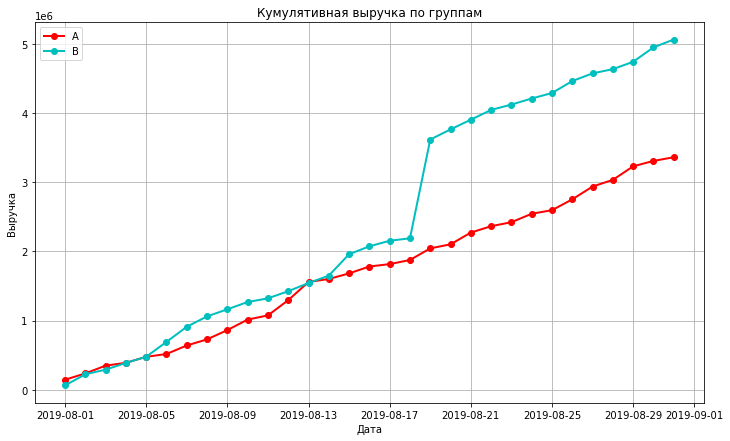

In [28]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12, 7))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A', linewidth = 2, marker='o', color = 'r')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B', linewidth = 2, marker='o', color='c')

plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid()
plt.legend();

Выручка почти равномерно увеличивается в течение всего теста. На графике видим, что в группе А выручка растет линейно, а в группе B были "всплеск" с районе 18.08.2019. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. При этом с 05.08.2019 выручка по группе B растет интенсивнее.

#### График кумулятивного среднего чека по группам

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

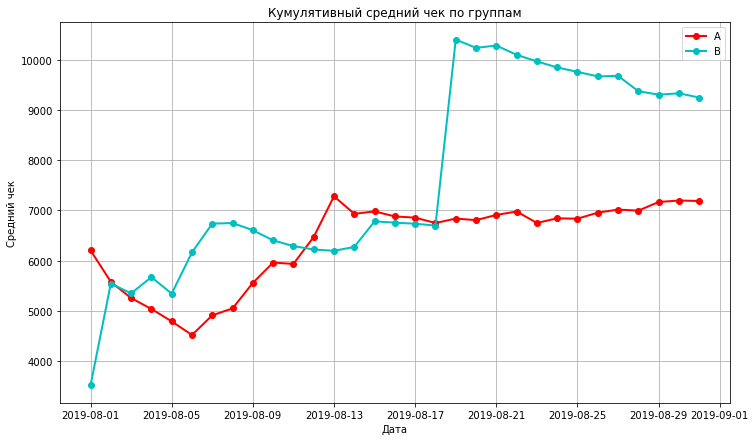

In [29]:
plt.figure(figsize=(12, 7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], 
         label='A', linewidth = 2, marker='o', color = 'r')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], 
         label='B', linewidth = 2, marker='o', color = 'c')

plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.grid()
plt.legend();

Видим аналогичную картину, с 18 августа средний чек группы B пошел в резкий отрыв от значений по группе A. В целом, средний чек  становится равномерным ближе к концу теста. Возможно, в группу B во второй половине теста попали крупные заказы (резкий всплеск на графике). Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

#### График относительного изменения кумулятивного среднего чека группы B к группе A

Построим график относительного различия для среднего чека:

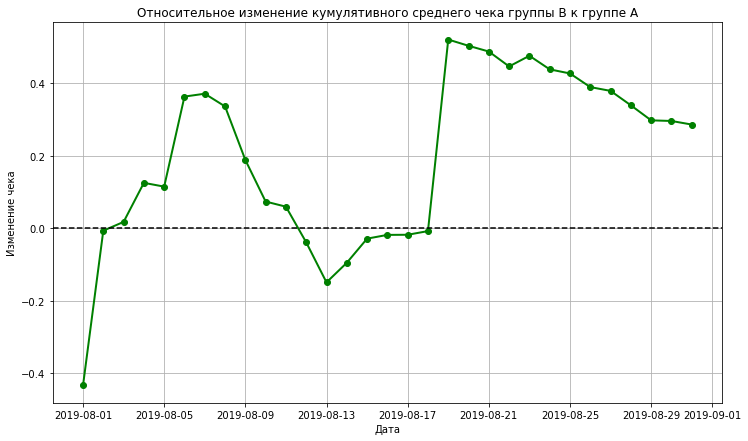

In [30]:
plt.figure(figsize=(12, 7))
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
                                                   left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1, linewidth = 2, marker='o', color = 'g' )

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Изменение чека')
plt.grid();

В нескольких точках график различия между сегментами резко «скачет». График подтверждает предыдущие догадки о существовании выбросов в покупках.

#### График кумулятивной конверсии по группам

Аналогично проанализируем график кумулятивной конверсии:

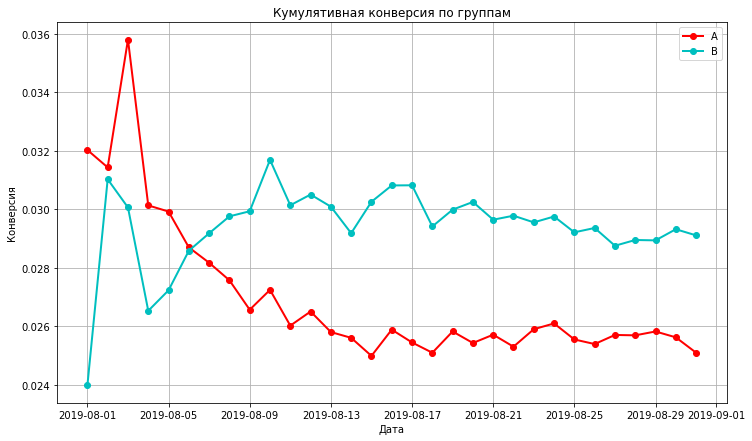

In [31]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(12, 7))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A', linewidth = 2, marker='o', color = 'r')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B', linewidth = 2, marker='o', color = 'c')
plt.legend()

plt.title('Кумулятивная конверсия по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.grid();

Группы колебались около одного значения, но затем 06.08.2019 конверсия группы B вырвалась вперёд  и зафиксировалась, а конверсия группы A просела и также зафиксировалась.

#### График относительного изменения кумулятивной конверсии группы B к группе A

Построим график относительного различия кумулятивных конверсий:

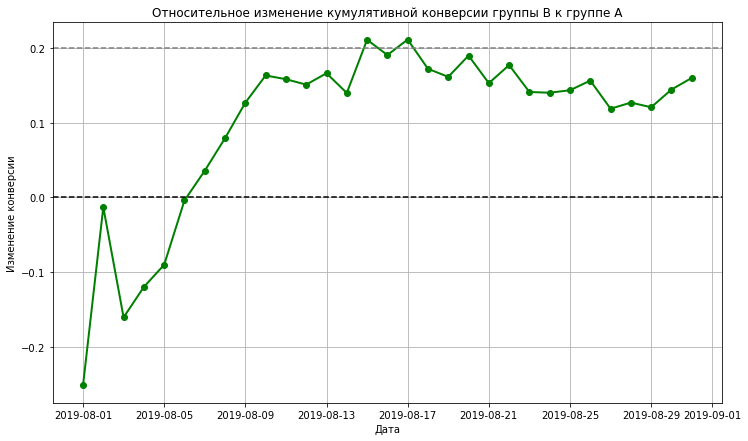

In [32]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], 
    left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12, 7))
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
         linewidth = 2, marker='o', color = 'g')

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Изменение конверсии')
plt.grid();

В начале теста группа B проигрывала группе A, затем резко скакнула 2 августа, но откатилась назад. Затем она начала постепенно расти и обошла конверсию группы А после 6 авгута, после чего стала немного падать, но все равно выигрывает по сравнению с группой А. В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Впрочем, сперва стоит проанализировать аномалии, возможно, они изменят картину.

#### Промежуточные выводы

* Выручка почти равномерно увеличивается в течение всего теста. На графике видим, что в группе А выручка растет линейно, а в группе B был "всплеск" с районе 18.08.2019. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. При этом с 05.08.2019 выручка по группе B растет инетнсивнее  
* с 18 августа средний чек группы B пошел в резкий отрыв от значений по группе A. В целом, средний чек становится равномерным ближе к концу теста. Возможно, в группу B во второй половине теста попали крупные заказы (резкий всплеск на графике)   
* конверсии групп колебались около одного значения, но затем 06.08.2019 конверсия группы B вырвалась вперёд и зафиксировалась, а конверсия группы A просела и также зафиксировалась  
* отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Необходимо детально проанализировать аномалии.

### Анализ выбросов и всплесков

#### Точечный график количества заказов по пользователям

Подсчитаем количество заказов по пользователям и посмотрим на результат:

In [33]:
ordersByUsers = (
    orders_clean.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['userId', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,userId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


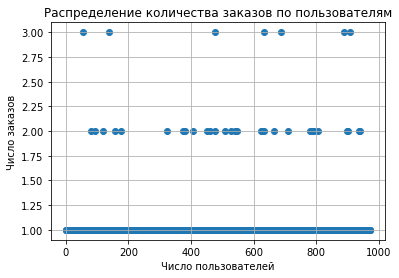

In [34]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Распределение количества заказов по пользователям')
plt.xlabel('Число пользователей')
plt.ylabel('Число заказов')
plt.grid();

Из графика видно,что подавляющее большинство пользователей оформляли всего 1 заказ, а максимальное количество заказов составило 3.

<div style="border:solid SandyBrown 2px; padding: 20px">
На данном этапе мне показалось странным, что распределение такое "красивое", поэтому я решила проверить аналогичные расчеты по сырым данным, до удаления пользователей, которые попали в обе группы, и вот, что обнаружилось:

In [35]:
ordersByUsers_1 = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers_1.columns = ['userId', 'orders']

ordersByUsers_1.sort_values(by='orders', ascending=False).head(10)

,userId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


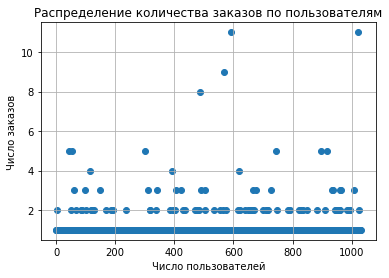

In [36]:
x_values = pd.Series(range(0,len(ordersByUsers_1)))
plt.scatter(x_values, ordersByUsers_1['orders'])
plt.title('Распределение количества заказов по пользователям')
plt.xlabel('Число пользователей')
plt.ylabel('Число заказов')
plt.grid();

Здесь мы видим, что количество заказов именно у этих пользователей и вносило аномалии в первоначальные данные.

#### 95-й и 99-й перцентили количества заказов на пользователя

In [37]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

Будем считать, что количество заказов более 2х уже аномально, тк это не более 1% пользователей.

#### Точечный график стоимостей заказов

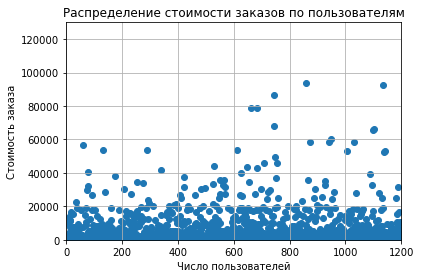

In [38]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.axis([0, 1200, 0, 130000])
plt.title('Распределение стоимости заказов по пользователям')
plt.xlabel('Число пользователей')
plt.ylabel('Стоимость заказа')
plt.grid();

По графику видно, что подавляющее большинство заказов на сумму до 40 000. Посмотрим на процентили.

#### 95-й и 99-й перцентили стоимости заказов

In [39]:
np.percentile(orders_clean['revenue'], [95, 99])

array([26785., 53904.])

Не более 5% заказов на сумму больше 26785 руб. И не более 1% пользователей - более 53904. Будем считать, что сумма заказа  свыше 50000 - аномалия.

#### Промежуточные выводы

Были построены графики распределения количества заказов и стоимости заказов, а также посчитаны 95-й и 99-й процентили. За аномалии будем принимать количество заказов свыше 2х и со стоимостью свыше 50 000. Пользователи, попавшие в обе исследуемые грыппу вносили самые значимые выбросы в количество заказов на пользователя.

### Анализ A/B-теста

#### Статистическая значимость различий в конверсии между группами по «сырым» данным

Подготовка данных к тесту:

In [40]:
visitorsADaily = visitors_clean[visitors_clean['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors_clean[visitors_clean['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders_clean[orders_clean['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders_clean[orders_clean['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,718,709,718,709
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,618,580,1336,1289
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,507,1843,1796
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,712,767,2555,2563
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,753,705,3308,3268


`date` — дата;  
`ordersPerDateA` — количество заказов в выбранную дату в группе A;  
`revenuePerDateA` — суммарная выручка в выбранную дату в группе A;  
`ordersPerDateB` — количество заказов в выбранную дату в группе B;  
`revenuePerDateB` — суммарная выручка в выбранную дату в группе B;  
`ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;  
`revenueCummulativeA` — суммарная выручка до выбранной даты включительно в группе A;  
`ordersCummulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;  
`revenueCummulativeB` — суммарная выручка до выбранной даты включительно в группе B;  
`visitorsPerDateA` — количество пользователей в выбранную дату в группе A;  
`visitorsPerDateB` — количество пользователей в выбранную дату в группе B;  
`visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A;  
`visitorsCummulativeB` — количество пользователей до выбранной даты включительно в группе B.

Создадим переменные ordersByUsersA и ordersByUsersB со столбцами `['userId', 'orders']`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [41]:
ordersByUsersA = (
    orders_clean[orders_clean['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

display(ordersByUsersA.head())
ordersByUsersB = (
    orders_clean[orders_clean['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']
display(ordersByUsersB.head())

,visitor_id,orders
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1


,visitor_id,orders
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1


Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [42]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() 
                                                                           - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() 
                                                                           - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Сформулируем гипотезы  

Н0 - различий в конверсиях между группами по «сырым» данным нет

Н1 - различия в конверсиях между группами по «сырым» данным есть

Пороговое значение alpha примем за 5%

In [43]:
print('P-value по конверсии до очистки данных:', "{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительный прирост конверсии группы B', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

alpha = .05

if (st.mannwhitneyu(sampleA, sampleB)[1]) < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value по конверсии до очистки данных: 0.011
Относительный прирост конверсии группы B 0.160
Отвергаем нулевую гипотезу


Анализ сырых данных показывает, что в конверсии между группами есть статистически значимые различия. Относительный прирост конверсии группы B к конверсии группы А равен 16%.

#### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем гипотезы

Н0 - различий в среднем чеке между группами по «сырым» данным нет

Н1 - различия в среднем чеке между группами по «сырым» данным есть

Пороговое значение alpha примем за 5%

In [44]:
p_val = st.mannwhitneyu(orders_clean[orders_clean['group']=='A']['revenue'], 
                        orders_clean[orders_clean['group']=='B']['revenue'])[1]
att = orders_clean[orders_clean['group']=='B']['revenue'].mean()/orders_clean[orders_clean['group']=='A']['revenue'].mean()-1

In [45]:
print('P-value по среднему чеку до очистки данных:', "{0:.3f}".format(p_val))
print('Относительный прирост среднего чека группы B', "{0:.3f}".format(att))

alpha = .05

if p_val < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value по среднему чеку до очистки данных: 0.829
Относительный прирост среднего чека группы B 0.287
Не получилось отвергнуть нулевую гипотезу


Анализ сырых данных показывает, что в среднем чеке между группами нет статистически значимых различий.

#### Статистическая значимость различий в конверсии между группами по «очищенным» данным

Сделаем срезы пользователей с числом заказов 3 и более — usersWithManyOrders и пользователей, совершивших заказы дороже 50 000 — usersWithExpensiveOrders. А также посмотрим количество аномальных пользователей.

In [46]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders_clean[orders_clean['revenue'] > 50000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
abnormalUsers.shape[0]

1099    148427295
33      249864742
58      611059232
1137    759473111
949     887908475
Name: visitor_id, dtype: int64


22

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [47]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Сформулируем гипотезы

Н0 - различий в конверсиях между группами по «очищенным» данным нет

Н1 - различия в конверсиях между группами по «очищенным» данным есть

Пороговое значение alpha примем за 5%

In [48]:
print('P-value по конверсии после очистки данных:', "{0:.3f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

print('Относительный прирост конверсии группы B', "{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

alpha = .05

if (st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]) < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value по конверсии после очистки данных: 0.006
Относительный прирост конверсии группы B 0.198
Отвергаем нулевую гипотезу


Анализ очищенных данных также показывает, что в конверсии между группами есть статистически значимые различия. Относительный прирост конверсии группы B к конверсии группы А равен 19,8%.

#### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [49]:
sampleAFiltered_rev = orders_clean[
                np.logical_and(
                    orders_clean['group'] == 'A',
                    np.logical_not(orders_clean['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue']
sampleBFiltered_rev = orders_clean[
                np.logical_and(
                    orders_clean['group'] == 'B',
                    np.logical_not(orders_clean['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue']

In [50]:
p_val_filtered = st.mannwhitneyu(sampleAFiltered_rev, sampleBFiltered_rev)[1]
att_filtered = sampleBFiltered_rev.mean()/sampleAFiltered_rev.mean()-1

In [51]:
print('P-value по среднему чеку после очистки данных:', "{0:.3f}".format(p_val_filtered))
print('Относительный прирост среднего чека группы B', "{0:.3f}".format(att_filtered))

alpha = .05

if p_val < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value по среднему чеку после очистки данных: 0.939
Относительный прирост среднего чека группы B 0.011
Не получилось отвергнуть нулевую гипотезу


Анализ очищенных данных также показывает, что в среднем чеке между группами нет статистически значимых различий.

#### Промежуточные выводы

Как по сырым данным, так и по очищенным тест дал одинаковые результаты - в конверсии между группами есть статистически значимые различия, по очищенным данным ее прирост составил 1,1%. Значительно снизился по сравнению с неочищенными данными. По среднему чеку статистически значимых различий между группами нет.


### Вывод

Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
По среднему чеку статистически значимых различий между группами нет.
График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения. По графику различия среднего чека группа В опережает группу А, но различия среднего чека колеблется и, исходя из результатов теста, делаем вывод, что это влияние выбросов и отличия не имеют значимости.
Тем не менее, тест можно остановить и признать успешным, перейти к проверке следующей гипотезы. Не смотря на отсутствие различий в группах по среднему чеку, в группе B конверсия выше, а значит выручка тоже будет выше.

## Общий вывод

В результате проекта были рассмотрены 9 гипотез интернет-магазина и выполнена их приоритизация двумя разными методами: RICE и ICE. По методу ICE наиболее приоритетная гипотеза - Запустить акцию, дающую скидку на товар в день рождения. По методу RICE - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок. Осовное отличие данных методов в том, что RICE также берет в расчет количество пользоватаелей, которых затронет изменение, которое мы хотим внести. И в случае с изменениями, которые затронут максимальное количество пользователей, гипотеза получает значительно больше баллов. Наименее приоритетная гипотеза по обоим фреймворкам - Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей.

Также во второй части проекта произведен анализ проведенного A/B-теста. Изучение данных показало, что было нарушено правило о непересечении участников групп между собой, 58 пользователей попало в обе группы, их заказы были удалены из анализа.

Анализ кумулятивных метрик показал, что:  
* выручка равномерно увеличивалась в течение всего теста. В группе А выручка росла линейно, а в группе B были "всплеск" с районе 18.08.2019. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. При этом с 05.08.2019 выручка по группе B росла интенсивнее
* с 18 августа средний чек группы B пошел в резкий отрыв от значений по группе A. В целом, средний чек стал равномерным ближе к концу теста. Возможно, в группу B во второй половине теста попали крупные заказы (резкий всплеск на графике)  
* конверсии групп колебались около одного значения, но затем 06.08.2019 конверсия группы B вырвалась вперёд и зафиксировалась, а конверсия группы A просела и также зафиксировалась.

Были проанализированы аномалии в данных:  
* построены графики распределения количества заказов и стоимости заказов, а также посчитаны 95-й и 99-й процентили 
* за аномалии были приняты количество заказов свыше 2х и со стоимостью свыше 50 000. В категорию аномалий попали менее 1% клиентов и чуть более 1% заказов.
* пользователи, попавшие в обе исследуемые группы вносили самые значимые выбросы в количество заказов на пользователя.    

На основе A/B-теста по сырым и очищенным данным были сделаны следующие выводы:  
* Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий   
* Относительный прирост конверсии группы B к конверсии группы А по очищенным данным составил всего 1,1%  
* По среднему чеку статистически значимых различий между группами нет
* Тест можно остановить и признать успешным, не смотря на отсутствие различий в группах по среднему чеку, в группе B конверсия выше, а значит выручка тоже будет выше.  